In [1]:
import random

from finrl.meta.env_portfolio_allocation import env_portfolio

import pandas as pd
import numpy as np
import gym
from typing import Callable, Tuple
from collections import defaultdict
from tqdm import trange


In [2]:
############STUFF GRABBED FROM FINRL TUTORIAL
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
import datetime

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from environments.portfolio_without_softmax import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline, convert_daily_return_to_pyfolio_ts
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
import sys

## 2.4. Create Folders
import os

if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

print(config_tickers.DOW_30_TICKER)
#dp = YahooFinanceProcessor()
#df = dp.download_data

df = YahooDownloader(start_date='2008-01-01',
                     end_date='2021-10-31',
                     ticker_list=config_tickers.DOW_30_TICKER).fetch_data()

df.head()
df.shape


C:\Users\wacho\Programming\RL_Finance\venv\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

(101615, 8)

In [3]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    use_turbulence=False,
    user_defined_feature=False)

df = fe.preprocess_data(df)
df.shape
df.head()

Successfully added technical indicators


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2008-01-02,7.116786,7.152143,6.876786,5.898640,1079178800,AAPL,2,0.0,5.90386,5.896147,100.0,-66.666667,100.0,5.898640,5.898640
3483,2008-01-02,46.599998,47.040001,46.259998,33.761417,7934400,AMGN,2,0.0,5.90386,5.896147,100.0,-66.666667,100.0,33.761417,33.761417
6966,2008-01-02,52.090000,52.320000,50.790001,39.587997,8053700,AXP,2,0.0,5.90386,5.896147,100.0,-66.666667,100.0,39.587997,39.587997
10449,2008-01-02,87.570000,87.839996,86.000000,63.481609,4303000,BA,2,0.0,5.90386,5.896147,100.0,-66.666667,100.0,63.481609,63.481609
13932,2008-01-02,72.559998,72.669998,70.050003,45.605476,6337800,CAT,2,0.0,5.90386,5.896147,100.0,-66.666667,100.0,45.605476,45.605476


In [4]:
df.tail()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
83591,2021-10-29,162.130005,162.440002,160.660004,153.936371,1314100,TRV,4,1.424915,156.635667,144.752568,55.691955,130.838051,19.622993,149.630910,150.155365
87074,2021-10-29,454.410004,461.390015,453.059998,447.971100,2497800,UNH,4,12.812441,459.914481,366.732080,67.009709,145.348238,52.064871,406.440813,405.562346
90557,2021-10-29,52.500000,53.049999,52.410000,46.802307,17763200,VZ,4,-0.170569,48.086327,45.189777,46.685000,-39.966421,12.569826,46.875142,47.474614
94040,2021-10-29,46.860001,47.279999,46.770000,41.523605,4999000,WBA,4,-0.169815,44.202654,40.524221,45.913451,-97.394942,0.268701,42.391108,42.889373
97523,2021-10-29,147.910004,150.100006,147.559998,144.852432,7340900,WMT,4,1.795644,147.887269,129.205251,59.710678,130.750319,35.423702,138.057021,140.642312


In [5]:

## Add covariance matrix as states
# add covariance matrix as states
df = df.sort_values(['date', 'tic'], ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback = 252
for i in range(lookback, len(df.index.unique())):
    data_lookback = df.loc[i - lookback:i, :]
    price_lookback = data_lookback.pivot_table(index='date', columns='tic', values='close')
    return_lookback = price_lookback.pct_change().dropna()
    return_list.append(return_lookback)

    covs = return_lookback.cov().values
    cov_list.append(covs)

df_cov = pd.DataFrame({'date': df.date.unique()[lookback:], 'cov_list': cov_list, 'return_list': return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date', 'tic']).reset_index(drop=True)

df.shape
df.head()


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2008-12-31,3.070357,3.133571,3.047857,2.583910,607541200,AAPL,2,-0.082603,3.093652,2.454291,42.254777,-80.462512,16.129793,2.749560,2.861671,"[[0.0013489672596163622, 0.0004284134003098699...",tic AAPL AMGN AXP ...
1,2008-12-31,57.110001,58.220001,57.060001,41.839535,6287200,AMGN,2,0.156757,42.707030,40.853198,51.060638,51.523601,10.432018,41.058035,40.603776,"[[0.0013489672596163622, 0.0004284134003098699...",tic AAPL AMGN AXP ...
2,2008-12-31,17.969999,18.750000,17.910000,14.580750,9625600,AXP,2,-0.935583,18.646872,12.660474,42.554845,-75.437679,25.776759,15.744065,17.616375,"[[0.0013489672596163622, 0.0004284134003098699...",tic AAPL AMGN AXP ...
3,2008-12-31,41.590000,43.049999,41.500000,32.005886,5443100,BA,2,-0.279801,32.174376,28.867835,47.440230,156.994889,5.366299,30.327211,32.389914,"[[0.0013489672596163622, 0.0004284134003098699...",tic AAPL AMGN AXP ...
4,2008-12-31,43.700001,45.099998,43.700001,29.608652,6277400,CAT,2,0.655611,30.348088,25.455652,51.205303,98.374106,26.331746,26.689551,26.423592,"[[0.0013489672596163622, 0.0004284134003098699...",tic AAPL AMGN AXP ...


In [6]:
## Training data split: 2009-01-01 to 2020-07-01
train = data_split(df, '2009-01-01', '2020-07-01')
trade = data_split(df, '2020-07-01', '2021-10-31')
train.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2009-01-02,3.067143,3.251429,3.041429,2.747391,746015200,AAPL,4,-0.070153,3.080130,2.452222,45.440211,-32.212727,2.140064,2.750408,2.862473,"[[0.001366149070380494, 0.0004339389447945097,...",tic AAPL AMGN AXP ...
0,2009-01-02,58.590000,59.080002,57.750000,42.737900,6547900,AMGN,4,0.232163,42.852625,40.817726,52.756862,92.828078,0.814217,41.122032,40.691923,"[[0.001366149070380494, 0.0004339389447945097,...",tic AAPL AMGN AXP ...
0,2009-01-02,18.570000,19.520000,18.400000,15.193845,10955700,AXP,4,-0.832049,18.463256,12.644439,43.957544,-42.853121,16.335101,15.742755,17.499519,"[[0.001366149070380494, 0.0004339389447945097,...",tic AAPL AMGN AXP ...
0,2009-01-02,42.799999,45.560001,42.779999,33.941093,7010200,BA,4,-0.002009,32.948621,28.452128,50.822036,272.813054,20.494464,30.469476,32.344129,"[[0.001366149070380494, 0.0004339389447945097,...",tic AAPL AMGN AXP ...
0,2009-01-02,44.910000,46.980000,44.709999,31.093399,7117200,CAT,4,0.833184,30.850187,25.434767,53.661254,129.524680,34.637448,26.926403,26.424174,"[[0.001366149070380494, 0.0004339389447945097,...",tic AAPL AMGN AXP ...


In [7]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym_random = StockPortfolioEnv(df = train, **env_kwargs)


Stock Dimension: 28, State Space: 28


In [8]:
import random
def random_agent(env: StockPortfolioEnv):
    env.reset()
    terminal = False
    while not terminal:
        action = [0] * len(env.action_space.sample())
        action[random.randint(0,  len(env.action_space.sample()) - 1)] = 1
        state, reward, terminal, _, _ = env.step(action)
    return env

In [9]:
# env_rand_post_training = random_agent(e_train_gym_random)

In [10]:

from typing import Dict
from agents.single_stock_tabular import PortfolioAction, update_single_stock_percent, convert_prices_to_discrete_state, \
    create_epsilon_policy


def generate_episode(env: StockPortfolioEnv, policy: Callable, stock: int = 0):
    """A function to generate one episode and collect the sequence of (s, a, r) tuples

    This function will be useful for implementing the MC methods

    Args:
        env (gym.Env): a Gym API compatible environment
        policy (Callable): A function that represents the policy.
    """
    episode = []
    state = env.reset()
    # get stock data to check movement
    env.step(np.zeros(28))
    previous_data = env.data
    env.step(np.zeros(28))
    current_data = env.data
    percent = 0
    S = convert_prices_to_discrete_state(prev_data_df=previous_data, current_data_df=current_data)

    while True:
        A = policy(S)
        A = A.value

        percent = update_single_stock_percent(percent, A)
        # convert our action into the portfolio percentages
        portfolio_breakdown = np.zeros(28)
        portfolio_breakdown[stock] = percent

        next_state, reward, done, _, _ = env.step(portfolio_breakdown)

        # update ticker prices
        previous_data = current_data
        current_data = env.data

        # create discrete next state
        next_state = convert_prices_to_discrete_state(prev_data_df=previous_data, current_data_df=current_data)

        # record information
        episode.append((S, A, reward, percent))
        S = next_state
        if done:
            break

    return episode


def on_policy_mc_control_single_stock(env: StockPortfolioEnv, num_episodes: int, gamma: float, epsilon: float, step_size: float,
                       stock: int = 0, q: Dict = None):
    if q is None:
        Q = defaultdict(lambda: np.zeros(len(PortfolioAction)))
    else:
        Q = q
    episodes = []
    returns = defaultdict(list)

    for _ in trange(num_episodes, desc="Episode", leave=False):
        policy = create_epsilon_policy(Q, epsilon)

        episode = generate_episode(env, policy, stock=stock)
        episodes.append(episode)
        G = 0
        for t in range(len(episode) - 1, -1, -1):
            G = (gamma * G) + episode[t][2]

            current_state, current_action, current_reward, percent = episode[t - 1]

            # Check if it's a first visit to the (state, action) pair
            state_action = (current_state, current_action)
            if state_action not in [(step[0], step[1]) for step in episode[:t - 1]]:
                returns[state_action].append(G)
                Q[current_state][current_action] = np.mean(returns[state_action])

    return env, episodes, Q

In [11]:
train_mc = StockPortfolioEnv(df = train, **env_kwargs)
_, episodes, Q = on_policy_mc_control_single_stock(train_mc, num_episodes=10, gamma=0.99, epsilon=0.5, step_size=0.5, stock=0)

Episode:   0%|          | 0/10 [00:00<?, ?it/s]

begin_total_asset:1000000
end_total_asset:6102110.282275152
Sharpe:  0.9684860875654643


Episode:  10%|█         | 1/10 [00:06<00:58,  6.51s/it]

begin_total_asset:1000000
end_total_asset:4535119.294372347
Sharpe:  0.8971374322947894


Episode:  20%|██        | 2/10 [00:14<00:59,  7.49s/it]

begin_total_asset:1000000
end_total_asset:6238052.503762872
Sharpe:  1.2204067075421312


Episode:  30%|███       | 3/10 [00:26<01:06,  9.50s/it]

begin_total_asset:1000000
end_total_asset:7171705.623598202
Sharpe:  1.0695499418474044


Episode:  40%|████      | 4/10 [00:45<01:19, 13.22s/it]

begin_total_asset:1000000
end_total_asset:3704871.0759088118
Sharpe:  0.7753627934529529


Episode:  50%|█████     | 5/10 [01:06<01:19, 15.86s/it]

begin_total_asset:1000000
end_total_asset:10112106.616162254
Sharpe:  1.1483696402611248


Episode:  60%|██████    | 6/10 [01:23<01:05, 16.27s/it]

begin_total_asset:1000000
end_total_asset:5992833.892577912
Sharpe:  1.0282161608799896


Episode:  70%|███████   | 7/10 [01:39<00:49, 16.47s/it]

begin_total_asset:1000000
end_total_asset:4625725.771692687
Sharpe:  0.9872230455902318


Episode:  80%|████████  | 8/10 [01:57<00:33, 16.83s/it]

begin_total_asset:1000000
end_total_asset:7439025.2076474875
Sharpe:  0.9697033718043399


Episode:  90%|█████████ | 9/10 [02:16<00:17, 17.45s/it]

begin_total_asset:1000000
end_total_asset:4441401.904799346
Sharpe:  0.8305778753884715


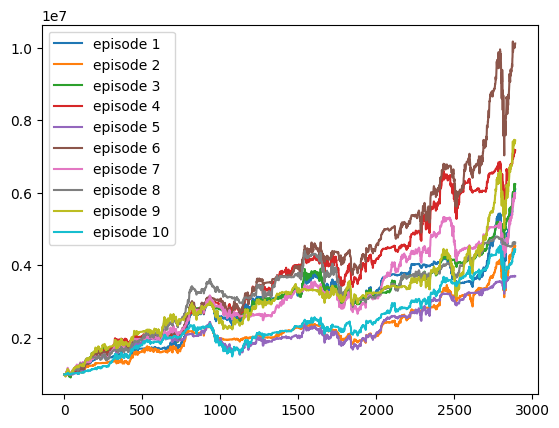

In [12]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
for idx, episode in enumerate(episodes):
    rewards = [e[2] for e in episode]

    plt.plot(list(range(len(rewards))), rewards, label=f"episode {idx + 1}")
plt.legend()
plt.show()

In [13]:
print(len(Q.keys()))

2763


In [14]:
print(Q.keys())

dict_keys([0, (1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 0, 2), (2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2), (2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 3), (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1), (2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2), (2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 3, 2, 2, 1), (2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2), (3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1), (1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1), (2, 2, 3, 1, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 3, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2), (2, 2, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 1, 2, 1, 3, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2), (0, 2, 2, 1, 2, 2, 1, 1, 2, 0, 2, 2, 1, 